In [ ]:
!nvidia-smi

Wed Nov 11 17:38:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import os
# sys.path.append('../src/')
sys.path.append(os.path.join('drive', 'My Drive', 'seznam'))
import os
import re
import gc
from tqdm.notebook import tqdm
import string
import nltk
import logging
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as sts

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,\
f1_score, roc_auc_score, classification_report  # plot_confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# import statsmodels.formula.api as smf
# import statsmodels.stats.api as sms
from plotly.offline import plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook
from functools import partial
from dl import ngram_vectorize

# from stop_words_cz import STOP_WORDS

register_matplotlib_converters()

pallet = 'ggplot'
plt.style.use(pallet)
cmap = ListedColormap(sns.color_palette())
# sns.set()

params = { 
    'figure.figsize': np.array([10, 6])
}
plt.rcParams.update(params)

# %config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data_folder = os.path.join('drive', 'My Drive', 'seznam')
data_cleaned = pd.read_csv(os.path.join(data_folder, 'data_cleaned.csv'), index_col=[0])
categories = data_cleaned.category.unique()
data_cleaned.head(2)

,category,rss_title,rss_perex,tot
0,biatlon,krčmář dojel hromadném závodě devátý díky skvě...,závod hromadným startem německém oberhofu česk...,krčmář dojel hromadném závodě devátý díky skvě...
1,biatlon,česká vlajka pokljuce vidět štafetách medaile ...,galerie,česká vlajka pokljuce vidět štafetách medaile ...


In [ ]:
# encode categories into ints
cat_encoder = LabelEncoder()
cat_encoder.fit(data_cleaned.category.values)
data_cleaned.category = cat_encoder.transform(data_cleaned.category.values)
data_cleaned.head(2)

,category,rss_title,rss_perex,tot
0,3,krčmář dojel hromadném závodě devátý díky skvě...,závod hromadným startem německém oberhofu česk...,krčmář dojel hromadném závodě devátý díky skvě...
1,3,česká vlajka pokljuce vidět štafetách medaile ...,galerie,česká vlajka pokljuce vidět štafetách medaile ...


In [ ]:
SEED = 12345

X, y = data_cleaned.drop(['category', 'rss_title', 'rss_perex'], axis=1), data_cleaned.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

X_train.shape, y_train.shape

((100094, 1), (100094,))

In [ ]:
ohe = pd.get_dummies(data_cleaned.category)
X_ohe = pd.concat([data_cleaned.tot, ohe], axis=1)
X_ohe.head(2)

,tot,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,krčmář dojel hromadném závodě devátý díky skvě...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,česká vlajka pokljuce vidět štafetách medaile ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe.tot, X_ohe.drop(['tot'], axis=1),
    test_size=0.1, stratify=y, random_state=SEED)

LSTM model

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [ ]:
# get tokens
vocabulary = 20_000
max_len = 50
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(X_train_ohe.values)
sequences = tokenizer.texts_to_sequences(X_train_ohe.values)
train = pad_sequences(sequences, maxlen=max_len)
sequences = tokenizer.texts_to_sequences(X_test_ohe.values)
test = pad_sequences(sequences, maxlen=max_len)

In [ ]:
model = Sequential()
model.add(Embedding(vocabulary, 100, input_length=max_len))
model.add(Dropout(0.2))
model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            6464      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2424      
Total params: 2,074,888
Trainable params: 2,074,888
Non-trainable params: 0
____________________________________________

In [ ]:
model.fit(
    train, y_train_ohe,
    batch_size=1024,
    epochs=15,
    verbose=1,
    validation_split=0.1,
    shuffle=True)

Epoch 1/15
88/88 [==============================] - 5s 59ms/step - loss: 1.8976 - accuracy: 0.4383 - val_loss: 1.2452 - val_accuracy: 0.6908
Epoch 2/15
88/88 [==============================] - 4s 49ms/step - loss: 0.7159 - accuracy: 0.8099 - val_loss: 0.4572 - val_accuracy: 0.8799
Epoch 3/15
88/88 [==============================] - 4s 49ms/step - loss: 0.3355 - accuracy: 0.9054 - val_loss: 0.2959 - val_accuracy: 0.9162
Epoch 4/15
88/88 [==============================] - 4s 49ms/step - loss: 0.1896 - accuracy: 0.9490 - val_loss: 0.2120 - val_accuracy: 0.9432
Epoch 5/15
88/88 [==============================] - 4s 49ms/step - loss: 0.1141 - accuracy: 0.9703 - val_loss: 0.1833 - val_accuracy: 0.9526
Epoch 6/15
88/88 [==============================] - 4s 49ms/step - loss: 0.0779 - accuracy: 0.9805 - val_loss: 0.1588 - val_accuracy: 0.9582
Epoch 7/15
88/88 [==============================] - 4s 48ms/step - loss: 0.0542 - accuracy: 0.9871 - val_loss: 0.1534 - val_accuracy: 0.9589
Epoch 8/15
88

In [ ]:
model.save(os.path.join(data_folder, 'lstm.bin'))

INFO:tensorflow:Assets written to: drive/My Drive/seznam/lstm.bin/assets


In [ ]:
print(classification_report(y_test, np.argmax(model.predict(test), axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       255
           1       0.73      0.79      0.76        14
           2       0.96      0.95      0.96       249
           3       0.97      0.97      0.97       153
           4       0.67      0.53      0.59        15
           5       0.92      0.92      0.92       205
           6       0.09      0.33      0.14         6
           7       0.86      0.83      0.85        53
           8       0.92      0.96      0.94       573
           9       0.99      0.99      0.99      4589
          10       0.29      0.50      0.36         4
          11       0.81      0.84      0.83        45
          12       0.94      0.73      0.82        67
          13       0.99      0.98      0.99      2878
          15       0.57      0.50      0.53         8
          16       0.89      0.86      0.88        96
          17       0.94      0.92      0.93       481
          18       0.73    

# BILSTM with fastest embeddings

In [ ]:
embs = pd.read_csv(os.path.join(data_folder, 'embeddings.csv'), index_col=[0])
embs.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0192,-0.0406,0.0511,0.0414,-0.0976,0.0159,0.0293,-0.0341,0.0223,0.0018,0.0268,-0.1222,0.0169,-0.0014,-0.137,0.0041,0.0228,0.0369,-0.0403,-0.0117,0.0309,0.0571,-0.0267,-0.0589,0.0675,0.0399,-0.045,0.0117,0.0395,-0.1315,0.0012,0.0614,0.058,0.0034,-0.0143,-0.0598,0.014,-0.0627,-0.0462,-0.0265,...,-0.1264,0.0401,-0.0357,0.0568,0.0302,-0.0569,0.0614,-0.004,-0.0877,0.0255,0.0199,0.0228,-0.014,-0.0486,0.043,-0.0199,0.0062,-0.1335,-0.0239,0.0461,-0.0915,0.0183,-0.0243,-0.0432,0.1076,0.0685,-0.0603,-0.1046,0.0079,-0.0197,0.0217,-0.0298,-0.0244,-0.0415,-0.0823,0.0305,0.0357,-0.0008,0.0122,-0.0676


In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, BatchNormalization
from keras.layers import  GlobalMaxPool1D, SpatialDropout1D
from keras.layers import Bidirectional
from keras.models import Model
from keras import optimizers

num_words, embedding_size = 20_000, 300
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
# Embedding layer for text inputs
input_words = Input((max_len, ))
x_words = Embedding(num_words, embedding_size, weights=[embs.values], trainable=False)(input_words)
x_words = SpatialDropout1D(0.3)(x_words)
x_words = Bidirectional(LSTM(100, return_sequences=True))(x_words)
x_words = Dropout(0.2)(x_words)
x_words = Conv1D(128, 1, strides = 1,  padding='causal', activation='relu', )(x_words)
x_words = Conv1D(256, 3, strides = 1,  padding='causal', activation='relu', )(x_words)
x_words = Conv1D(512, 5, strides = 1,   padding='causal', activation='relu', )(x_words)
x_words = GlobalMaxPool1D()(x_words)
x_words = Dropout(0.2)(x_words)

x = Dense(50, activation='relu')(x_words)
x = Dropout(0.2)(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=[input_words], outputs=predictions)
model.compile(optimizer='rmsprop' ,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           25728     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 256)          

In [ ]:
history = model.fit(
    train, y_train_ohe,
    epochs=30, verbose=1,
    batch_size=1024, callbacks=[early_stop],
    validation_split=0.1, shuffle=True)

Epoch 1/30
88/88 [==============================] - 14s 156ms/step - loss: 1.9991 - accuracy: 0.3944 - val_loss: 1.6691 - val_accuracy: 0.4566
Epoch 2/30
88/88 [==============================] - 13s 145ms/step - loss: 1.5634 - accuracy: 0.5076 - val_loss: 1.2946 - val_accuracy: 0.5796
Epoch 3/30
88/88 [==============================] - 13s 142ms/step - loss: 1.3850 - accuracy: 0.5587 - val_loss: 1.2295 - val_accuracy: 0.6209
Epoch 4/30
88/88 [==============================] - 12s 141ms/step - loss: 1.2664 - accuracy: 0.6009 - val_loss: 1.0755 - val_accuracy: 0.6730
Epoch 5/30
88/88 [==============================] - 12s 141ms/step - loss: 1.1464 - accuracy: 0.6425 - val_loss: 1.0191 - val_accuracy: 0.6887
Epoch 6/30
88/88 [==============================] - 12s 141ms/step - loss: 1.0416 - accuracy: 0.6755 - val_loss: 0.9125 - val_accuracy: 0.7178
Epoch 7/30
88/88 [==============================] - 12s 141ms/step - loss: 0.9434 - accuracy: 0.7103 - val_loss: 0.8134 - val_accuracy: 0.7490

In [ ]:
model.save(os.path.join(data_folder, 'model_bilstm.bin'))

INFO:tensorflow:Assets written to: drive/My Drive/seznam/model_bilstm.bin/assets


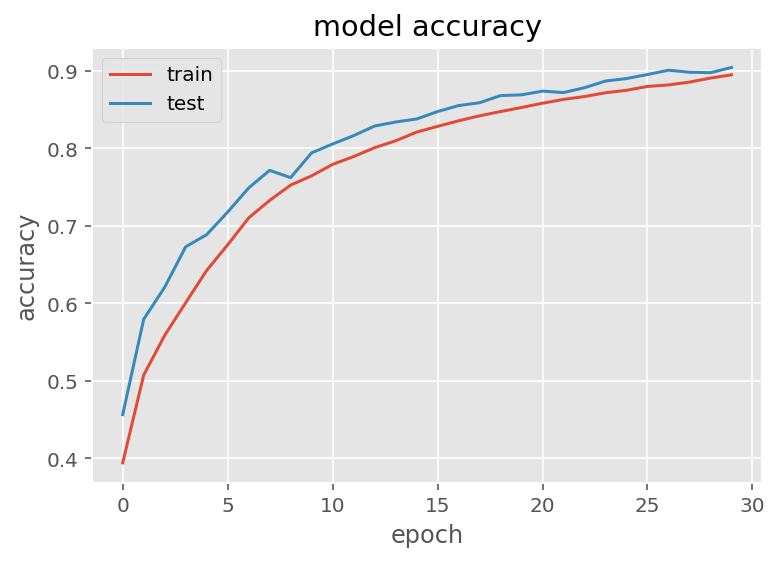

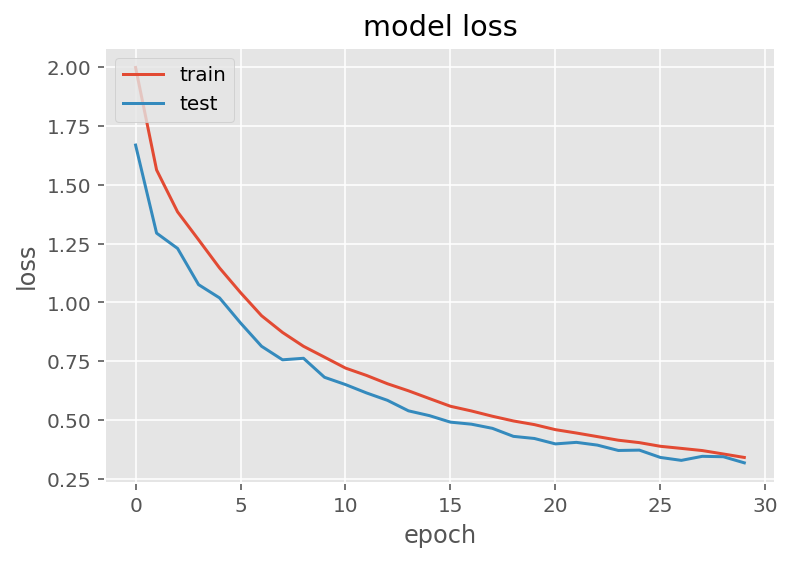

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(classification_report(y_test, np.argmax(model.predict(test), axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       255
           1       0.00      0.00      0.00        14
           2       0.96      0.82      0.88       249
           3       0.85      0.82      0.83       153
           4       0.00      0.00      0.00        15
           5       0.84      0.77      0.80       205
           6       0.00      0.00      0.00         6
           7       1.00      0.79      0.88        53
           8       0.84      0.94      0.88       573
           9       0.90      0.98      0.94      4589
          10       0.00      0.00      0.00         4
          11       0.90      0.60      0.72        45
          12       0.95      0.58      0.72        67
          13       0.95      0.90      0.92      2878
          15       0.00      0.00      0.00         8
          16       0.73      0.62      0.67        96
          17       0.99      0.85      0.91       481
          18       0.72    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Try LSTM with ~ balanced data

In [ ]:
data_mutated = pd.read_csv(os.path.join(data_folder, 'data_mutated.csv'), index_col=[0])
print(data_mutated.shape)
data_mutated.head(2)

(113431, 2)


,tot,category
0,krčmář dojel hromadném závodě devátý díky skvě...,3
1,česká vlajka pokljuce vidět štafetách medaile ...,3


In [ ]:
X, y = data_mutated.drop(['category'], axis=1), data_mutated.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

X_train.shape, y_train.shape
ohe = pd.get_dummies(data_mutated.category)
X_ohe = pd.concat([data_mutated.tot, ohe], axis=1)

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe.tot, X_ohe.drop(['tot'], axis=1),
    test_size=0.1, stratify=y, random_state=SEED)

((102087, 1), (102087,))

In [ ]:
# get tokens
vocabulary = 20_000
max_len = 50
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(X_train_ohe.values)
sequences = tokenizer.texts_to_sequences(X_train_ohe.values)
train = pad_sequences(sequences, maxlen=max_len)
sequences = tokenizer.texts_to_sequences(X_test_ohe.values)
test = pad_sequences(sequences, maxlen=max_len)

In [ ]:
model = Sequential()
model.add(Embedding(vocabulary, 100, input_length=max_len))
model.add(Dropout(0.2))
model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            6464      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2424      
Total params: 2,074,888
Trainable params: 2,074,888
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(
    train, y_train_ohe,
    batch_size=1024,
    epochs=20,
    verbose=1,
    validation_split=0.1,
    shuffle=True)

Epoch 1/30
90/90 [==============================] - 6s 63ms/step - loss: 1.9774 - accuracy: 0.4262 - val_loss: 1.3466 - val_accuracy: 0.6284
Epoch 2/30
90/90 [==============================] - 5s 52ms/step - loss: 0.8952 - accuracy: 0.7609 - val_loss: 0.6145 - val_accuracy: 0.8338
Epoch 3/30
90/90 [==============================] - 5s 53ms/step - loss: 0.4494 - accuracy: 0.8819 - val_loss: 0.4047 - val_accuracy: 0.8942
Epoch 4/30
90/90 [==============================] - 5s 54ms/step - loss: 0.2661 - accuracy: 0.9269 - val_loss: 0.2568 - val_accuracy: 0.9297
Epoch 5/30
90/90 [==============================] - 5s 53ms/step - loss: 0.1645 - accuracy: 0.9540 - val_loss: 0.2140 - val_accuracy: 0.9383
Epoch 6/30
90/90 [==============================] - 5s 52ms/step - loss: 0.1090 - accuracy: 0.9708 - val_loss: 0.1807 - val_accuracy: 0.9530
Epoch 7/30
90/90 [==============================] - 5s 52ms/step - loss: 0.0730 - accuracy: 0.9828 - val_loss: 0.1643 - val_accuracy: 0.9567
Epoch 8/30
90

In [ ]:
print(classification_report(y_test, np.argmax(model.predict(test), axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       255
           1       0.94      0.88      0.91        50
           2       0.96      0.95      0.95       249
           3       0.98      0.93      0.96       153
           4       0.88      0.74      0.80        50
           5       0.96      0.93      0.95       205
           6       0.80      0.80      0.80        30
           7       0.94      0.85      0.89        53
           8       0.92      0.97      0.95       573
           9       0.98      0.99      0.99      4589
          10       0.64      1.00      0.78        30
          11       0.83      0.84      0.84        45
          12       0.83      0.93      0.87        67
          13       0.98      0.98      0.98      2878
          14       0.91      1.00      0.95        30
          15       0.75      0.80      0.77        30
          16       0.94      0.91      0.92        96
          17       0.97    